In [1]:
import matplotlib.pyplot as plt
import proplot
import torch
import random
%run ../r2d2_algo/r2d2_class.py

In [2]:
env_kwargs = {
        'num_objects': 0, 'rew_structure': 'goal',
        'task_structure': 2, 'wall_colors': 4,
        'num_rays': 12, 'fov': 1
}

agent = R2D2Agent(env_id='NavEnv-v0', env_kwargs=env_kwargs,
                 verbose=1, batch_size=256, buffer_size=20000,
                 burn_in_length=8)

In [3]:
agent.collect(10000)

Mean episode length 193.8, mean return 0.2
Mean episode length 202.0, mean return 0.0
Mean episode length 202.0, mean return 0.0
Mean episode length 202.0, mean return 0.0
Mean episode length 202.0, mean return 0.0


In [20]:
agent.update()

In [41]:
'''Run steps manually'''

obs = agent.env.reset()
rnn_hxs = agent.q_network.get_rnn_hxs()
for i in range(500):
    action, q_values, next_rnn_hxs = agent.act(obs, rnn_hxs)
    next_obs, reward, done, info = agent.env.step(action.item())
    
    if reward == 1:
        break
        
    if done:
        next_obs = agent.env.reset()
        next_rnn_hxs = agent.q_network.get_rnn_hxs()
    
    obs = next_obs
    rnn_hxs = next_rnn_hxs

0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0.0 False
0 False
0 False
0.0 False
0 False
0.0 False
0.0 False
0 False
0.0 False
0 False
0 False
0 False
0 False
0.0 False
0 False
0 False
0 False
0 False
0.0 False
0 False
0.0 False
0 False
0 False
0 False
0.0 False
0 False
0.0 False
0.0 False
0 False
0 False
0.0 False
0 False
0 False
0 False
0.0 False
0 False
0 False
0 False
0 Fals

# Optimizing batch calls for ResettingGRU

Running three 1 row GRU calls takes about as much time as 1 batched 64 GRU call. 

Padding adds linearly more time as well. To optimize then, it makes sense to batch

## Testing times to finish forward calls adding rows or sequence length steps

In [64]:
agent = R2D2Agent()
agent.train(1)
data = agent.rb.sample(64)

obs = data['observations']
dones = data['dones']
rnn_hxs = data['hidden_states']

In [82]:
dones.sum()

tensor(40.)

In [65]:
%%timeit
agent.q_network.gru(obs, rnn_hxs)

2.94 ms ± 28.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [87]:
%%timeit
agent.q_network.gru(obs[:-1], rnn_hxs[:, :-1, :])

2.9 ms ± 59.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [80]:
%%timeit
agent.q_network.gru(obs[:, :-1, :], rnn_hxs)

2.64 ms ± 74.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [74]:
%%timeit
agent.q_network.gru(torch.concat([obs, obs], dim=1), rnn_hxs)

6.11 ms ± 140 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [97]:
%%timeit
agent.q_network.gru(torch.concat([obs[:-1], obs[:-1]], dim=1), rnn_hxs[:, :-1, :])

6.16 ms ± 109 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [102]:
%%timeit
agent.q_network.gru(torch.concat([obs]*4, dim=1), rnn_hxs)

11.9 ms ± 231 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [101]:
%%timeit
agent.q_network.gru(torch.concat([obs[:-1]]*4, dim=1), rnn_hxs[:, :-1, :])

11.8 ms ± 187 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [75]:
obs.shape

torch.Size([64, 12, 4])

In [84]:
%%timeit
agent.q_network.gru(obs[:1, :4, :], rnn_hxs[:, :1, :])

374 µs ± 8.53 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [83]:
%%timeit
agent.q_network.gru(obs[:1, :1, :], rnn_hxs[:, :1, :])

131 µs ± 916 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [103]:
empty = torch.zeros((64, 12, 4))

In [104]:
%%timeit
empty[:, 4:8, :] = obs[:, 4:8, :]

10.5 µs ± 191 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [106]:
dones.sum()

tensor(40.)

## Testing rebatched ResettingGRU, 

In [488]:
class ResettingGRU2(nn.Module):
    '''
    Modification to GRU that can take dones on the forward call to tell when
    state in the middle of a batched sequence forward call should be reset
    '''
    def __init__(self, **kwargs):
        super().__init__()
        self.gru = nn.GRU(**kwargs)
        
        self.hidden_size = self.gru.hidden_size
        self.batch_first = self.gru.batch_first
        
    def get_rnn_hxs(self, num_batches=1):
        '''
        Get torch.zeros hidden states to start off with
        '''
        if num_batches == 1:
            return torch.zeros(1, self.hidden_size)
        else:
            return torch.zeros(1, num_batches, self.hidden_size)
        
    
    def forward(self, x, hidden_state, dones=None):
        if dones == None:
            return self.gru(x, hidden_state)
        
        #Unfortunately need to split up the batch here
        if self.batch_first == False:
            raise NotImplementedError
        
        if hidden_state.dim() == 2:
            hidden_state = hidden_state.unsqueeze(0)
            x = x.unsqueeze(0)
            dones = dones.unsqueeze(0)

        num_batches = hidden_state.shape[1]

        #Generate a new padded x and rnn_hxs vector to batch forward pass
        padded_x = torch.zeros((num_batches + extra_rows, x.shape[1], x.shape[2]))
        padded_rnn_hxs = torch.zeros((hidden_state.shape[0], num_batches + extra_rows, hidden_state.shape[2]))

        batchable_rows = (dones == 0).all(dim=1)
        num_batchable_rows = batchable_rows.sum().item()
        individual_rows = (~batchable_rows).argwhere().reshape(-1)

        #First N rows will be taken from rows with no dones
        padded_x[:num_batchable_rows] = x[batchable_rows]
        padded_rnn_hxs[:, :num_batchable_rows, :] = hidden_state[:, batchable_rows, :]

        #Remaining rows will be filled out in order of rows with dones
        cur_row_idx = num_batchable_rows
        for i in individual_rows:
            breakpoints = (dones[i] == 1).argwhere()
            cur_idx = 0
            rnn_hx = hidden_state[:, i, :]

            for breakpoint in breakpoints:
                if breakpoint == 0:
                    rnn_hx = get_rnn_hxs()
                    continue
                padded_x[cur_row_idx, :breakpoint-cur_idx, :] = x[i, cur_idx:breakpoint, :]
                padded_rnn_hxs[:, cur_row_idx, :] = rnn_hx

                rnn_hx = get_rnn_hxs()
                cur_idx = breakpoint
                cur_row_idx += 1

            if cur_idx < len(dones[i]):
                padded_x[cur_row_idx, :len(dones[i])-cur_idx, :] = x[i, cur_idx:, :]
                padded_rnn_hxs[:, cur_row_idx, :] = rnn_hx
                cur_row_idx += 1

        #Perform forward pass on new batched
        output, output_hx = self.gru(padded_x, padded_rnn_hxs)

        #Fill out the expected output by reversing the whole process
        full_out = torch.zeros((x.shape[0], x.shape[1], self.hidden_size))
        full_hx_out = torch.zeros((1, x.shape[0], self.hidden_size))

        full_out[batchable_rows] = output[:num_batchable_rows]
        full_hx_out[:, batchable_rows, :] = output_hx[:, :num_batchable_rows, :]

        cur_row_idx = num_batchable_rows
        for i in individual_rows:
            breakpoints = (dones[i] == 1).argwhere()
            cur_idx = 0

            for breakpoint in breakpoints:
                if breakpoint == 0:
                    continue
                full_out[i, cur_idx:breakpoint, :] = output[cur_row_idx, :breakpoint-cur_idx, :]

                cur_idx = breakpoint
                cur_row_idx += 1

            if cur_idx < len(dones[i]):
                full_out[i, cur_idx:, :] = output[cur_row_idx, :len(dones[i])-cur_idx, :]
                
                print(cur_row_idx)
                #Remember only the last rnn hidden state gets returned
                full_hx_out[:, i, :] = output_hx[:, cur_row_idx, :]
                cur_row_idx += 1
            else:
                #If we did not have remaining steps to fill, then we must have had a done
                # on the last step, so the final rnn_hx should be zeros to return
                full_hx_out[:, i, :] = self.get_rnn_hxs()

        return full_out, full_hx_out, padded_x, padded_rnn_hxs, output, output_hx

In [390]:

class ResettingGRU(nn.Module):
    '''
    Modification to GRU that can take dones on the forward call to tell when
    state in the middle of a batched sequence forward call should be reset
    '''
    def __init__(self, **kwargs):
        super().__init__()
        self.gru = nn.GRU(**kwargs)
        
        self.hidden_size = self.gru.hidden_size
        self.batch_first = self.gru.batch_first
        
    def get_rnn_hxs(self, num_batches=1):
        '''
        Get torch.zeros hidden states to start off with
        '''
        if num_batches == 1:
            return torch.zeros(1, self.hidden_size)
        else:
            return torch.zeros(1, num_batches, self.hidden_size)
        
    
    def forward(self, x, hidden_state, dones=None):
        if dones == None:
            return self.gru(x, hidden_state)
        
        #Unfortunately need to split up the batch here
        if self.batch_first == False:
            raise NotImplementedError        
        
        def single_gru_row(x_i, rnn_hx, done):
            breakpoints = (done == 1).argwhere()
            cur_idx = 0
            output_row = torch.zeros(x_i.shape[0], self.hidden_size)
            
            for breakpoint in breakpoints:
                if breakpoint == 0:
                    rnn_hx = self.get_rnn_hxs()
                    continue
                out, out_hx = self.gru(x_i[cur_idx:breakpoint], rnn_hx)
                output_row[cur_idx:breakpoint] = out
                rnn_hx = self.get_rnn_hxs()
                cur_idx = breakpoint
                
            if cur_idx < x_i.shape[0]:
                out, out_hx = self.gru(x_i[cur_idx:], rnn_hx)
                output_row[cur_idx:] = out
            return output_row, out_hx
        
        if hidden_state.dim() == 2:
            output, output_hx = single_gru_row(x, hidden_state, dones)
            
        else:
            num_batches = hidden_state.shape[1]
            
            # Output will have shape [N, L, hidden_size]
            full_out = torch.zeros((x.shape[0], x.shape[1], self.hidden_size))
            # hidden_state output has shape [1, N, hidden_size]
            full_hx_out = torch.zeros((1, x.shape[0], self.hidden_size))
            
            batchable_rows = (dones == 0).all(dim=1)
            individual_rows = (~batchable_rows).argwhere().reshape(-1)
            
            # First batch all computations that have no dones in them
            out, out_hx = self.gru(x[batchable_rows], hidden_state[:, batchable_rows, :])
            full_out[batchable_rows] = out
            full_hx_out[:, batchable_rows, :] = out_hx
            
            for i in individual_rows:
                d = dones[i]
                x_i = x[i]
                rnn_hx = hidden_state[:, i, :]
                
                output_row, output_hx_row = single_gru_row(x_i, rnn_hx, d)
                full_out[i] = output_row
                full_hx_out[:, i, :] = output_hx_row
            
        
        return full_out, full_hx_out

In [74]:
%%timeit
agent.q_network.gru(torch.concat([obs, obs], dim=1), rnn_hxs)

6.11 ms ± 140 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [97]:
%%timeit
agent.q_network.gru(torch.concat([obs[:-1], obs[:-1]], dim=1), rnn_hxs[:, :-1, :])

6.16 ms ± 109 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [489]:
gru2 = ResettingGRU2(input_size=4, hidden_size=64, batch_first=True)

In [470]:
gru = ResettingGRU(input_size=4, hidden_size=64, batch_first=True)

In [ ]:
# %%timeit
out1, hx1 = gru(obs, rnn_hxs, dones)

In [490]:
# %%timeit
out2, hx2, padded_x, padded_rnn_hxs, output, output_hx = gru2(obs, rnn_hxs, dones)

26
28
30
32
33
35
37
39
41
43
45
47
49
51
53
54
56
58
60
61
64
66
68
70
72
74
76
78
80
82
84
85
87
89
91
93
95
97
99


In [424]:
# Check that we get same result for output after rebatching

(out1 - out2)[1]

tensor([[-7.4506e-09,  2.7940e-09,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00, -7.4506e-09,  0.0000e+00,  0.0000e+00,  3.7253e-09,
          0.0000e+00,  0.0000e+00, -7.4506e-09,  7.4506e-09,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -1.4901e-08,
          0.0000e+00, -1.4901e-08, -3.7253e-09,  1.4901e-08,  0.0000e+00,
         -7.4506e-09,  0.0000e+00, -9.3132e-10,  0.0000e+00,  0.0000e+00,
          1.4901e-08,  0.0000e+00,  0.0000e+00,  1.8626e-09,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  1.4901e-08,  7.4506e-09,
          3.7253e-09,  7.4506e-09,  0.0000e+00,  0.0000e+00],
        [-1.4901e-08,  1.8626e-09,  3.7253e-09, -1

In [ ]:
# Note that we do NOT get the same result for the hidden state output since padding adds
#  steps of zeros which cause more evolution in rnn_hxs output
(hx1 - hx2)[1]

# Testing policy

Actually this Q learning agent seems to learn much better direct navigation rather than the corner testing of previous agents

In [26]:
# Assume recurrent policy

env_kwargs = {
    'num_objects': 0, 'rew_structure': 'goal',
    'task_structure': 2, 'wall_colors': 4,
    'num_rays': 12, 'fov': 1
}
env = gym.make('NavEnv-v0', **env_kwargs)
qnet = torch.load('../saved_models/mwm_base1_t0.pt')
agent = R2D2Agent(q_network=qnet, deterministic=False, env=env,
                 start_e=0.05, end_e=0.05)

def evaluate_policy(agent, num_episodes=10):
    
    ep_lengths = []
    ep_returns = []
    
    ep_l = 0
    ep_r = 0
    for t in range(num_episodes):
        obs = agent.env.reset()
        rnn_hxs = agent.q_network.get_rnn_hxs()
        while True:
            action, q_values, next_rnn_hxs = agent.act(obs, rnn_hxs)
            next_obs, reward, done, info = agent.env.step(action.item())
            
            ep_l += 1
            ep_r += reward
            if done:
                next_obs = agent.env.reset()
                next_rnn_hxs = agent.q_network.get_rnn_hxs()
                
                ep_lengths.append(ep_l)
                ep_returns.append(ep_r)
                ep_l = 0
                ep_r = 0
                break
                
            obs = next_obs
            rnn_hxs = next_rnn_hxs
    return ep_lengths, ep_returns

In [80]:
def evaluate_agent(agent, data_callback=None,
             num_episodes=10, verbose=0, with_activations=False):
    '''
    data_callback: a function that should be called at each step to pull information
        from the environment if needed. The function will take arguments
            def callback(actor_critic, vec_envs, recurrent_hidden_states, data):
        actor_critic: the actor_critic network
        vec_envs: the vec envs (can call for example vec_envs.get_attr('objects') to pull data)
        recurrent_hidden_states: these are given in all data, but may want to use in computation
        obs: observation this step (after taking action) - 
            note that initial observation is never seen by data_callback
            also note that this observation will have the mean normalized
            so may instead want to call vec_envs.get_method('get_observation')
        action: actions this step
        reward: reward this step
        data: a data dictionary that will continuously be passed to be updated each step
            it will start as an empty dicionary, so keys must be initialized
        see below at example_data_callback in this file for an example
    '''
    ep_rewards = []
    
    ep_r = 0

    all_obs = []
    all_actions = []
    all_rewards = []
    all_hidden_states = []
    all_dones = []
    all_activations = []
    data = {}

    obs = agent.env.reset()
    rnn_hxs = agent.q_network.get_rnn_hxs()

    step = 0
    for i in range(num_episodes):
        while True:
            all_hidden_states.append(rnn_hxs)
            
            with torch.no_grad():
                action, q_values, rnn_hxs = agent.act(obs, rnn_hxs)

            obs, reward, done, infos = agent.env.step(action)

            all_obs.append(obs)
            all_actions.append(action)
            all_rewards.append(reward)
            all_dones.append(done)

            if with_activations:
                all_activations.append(outputs['activations'])

            if data_callback is not None:
                data = data_callback(agent, env, rnn_hxs,
                    obs, action, reward, done, data)
            else:
                data = {}
                
            if done:
                obs = agent.env.reset()
                rnn_hxs = agent.q_network.get_rnn_hxs()
                ep_rewards.append(ep_r)
                ep_r = 0
                break

            step += 1

    if verbose >= 1:
        print(" Evaluation using {} episodes: mean reward {:.5f}\n".format(
            len(ep_rewards), np.mean(ep_rewards)))

    return {
        'obs': all_obs,
        'actions': all_actions,
        'rewards': all_rewards,
        'hidden_states': all_hidden_states,
        'dones': all_dones,
        'data': data,
        'activations': all_activations,
    }


def nav_data_callback(actor_critic, vec_envs, recurrent_hidden_states,
                                  obs, action, reward, done, data):
    if data == {}:
        data['pos'] = []
        data['angle'] = []
    
    # pos = [c.pos.copy() for c in vec_envs.get_attr('character')]
    # angle = [c.angle for c in vec_envs.get_attr('character')]
    pos = env.character.pos.copy()
    angle = env.character.angle
    data['pos'].append(pos)
    data['angle'].append(angle)
    
    return data

In [81]:
res = evaluate_agent(agent, nav_data_callback)

In [94]:
def split_by_ep(targets, dones):
    '''
    Given a collection of res data from an evalu() call, split up
    the data by episodes using res['dones']. Uses the True values from
    dones list to tell when a 
    
    For example, 
    res = evalu(...)
    ep_pos = split_by_ep(res['data']['pos'], res['dones'])
    '''
    done_idxs = np.where(np.vstack(dones))[0]
    split_targets = []
    for i in range(len(done_idxs)):
        if i == 0:
            done_targets = targets[:done_idxs[i]]
        else:
            done_targets = targets[done_idxs[i-1]:done_idxs[i]]

        split_targets.append(done_targets)
    return split_targets

def draw_trajectory(pos=None, angle=None, fig=None, ax=None):
    '''Convert positions and angles into an image trajectory
    Adds a few extra details like where the start and goal reached locations are
    as well as adding increasing redness as the agent spends time in one spot rotating
    without forward movement'''
    if fig == None and ax == None:
        fig, ax = pplt.subplots()
    stopped = 0
    last_p = np.zeros(2)
    for i, (p, a) in enumerate(zip(pos, angle)):
        redness = max(0, 1-stopped*0.1)
        color = [1, redness, redness, 1]
        draw_character(p, a, ax=ax, color=color)

        if (p == last_p).all():
            stopped += 1
        else:
            stopped = 0
        last_p = p

    #redraw first and last steps
    draw_character(pos[0], angle[0], color=[0, 1, 0, 1], size=18, ax=ax)
    if len(pos) < 202:
        draw_character(pos[-1], angle[-1], color=[0, 1, 1, 1], size=18, ax=ax)
    ax.format(xlim=[0, 300], ylim=[0, 300])
    
    return fig, ax


def draw_character(pos, angle, size=10, ax=None, color=None):
    '''
    Given a position and angle, draw character to the given axis
    '''
    angle1 = angle - 0.3
    angle2 = angle + 0.3
    point1 = [pos[0], pos[1]]
    point2 = [pos[0] - np.cos(angle1)*size, pos[1] - np.sin(angle1)*size]
    point3 = [pos[0] - np.cos(angle2)*size, pos[1] - np.sin(angle2)*size]

    if color is None:
        color = np.array([0.9, 0.9, 0])

    poly = plt.Polygon([point1, point2, point3], fc=color)
    if ax is None:
        plt.gca().add_patch(poly)
    else:
        ax.add_patch(poly)
        
        
def set_trajectory_plot_style(reset=False):
    '''Set up rc params for proplot so that we get nice images to feed into
    the visual system for ananlysis
    
    If reset == True, revert to default rcprams for normal plotting'''
    if reset:
        pplt.rc.reset()
    else:
        pplt.rc.update({
            'axes.spines.bottom': False,
            'axes.spines.top': False,
            'axes.spines.left': False,
            'axes.spines.right': False,
            'axes.facecolor': 'black',
            'axes.grid': False
        })
    

In [87]:
set_trajectory_plot_style()

In [82]:
ep_dones = split_by_ep(res['dones'], res['dones'])
ep_pos = split_by_ep(res['data']['pos'], res['dones'])
ep_angle = split_by_ep(res['data']['angle'], res['dones'])

In [47]:
[len(d) for d in ep_dones]

[75, 9, 49, 202, 74, 187, 115, 34, 202, 94]

In [52]:
import matplotlib.pyplot as plt
import proplot as pplt

In [102]:
i = 0

(Figure(nrows=1, ncols=1, refwidth=2.5),
 SubplotGrid(nrows=1, ncols=1, length=1))

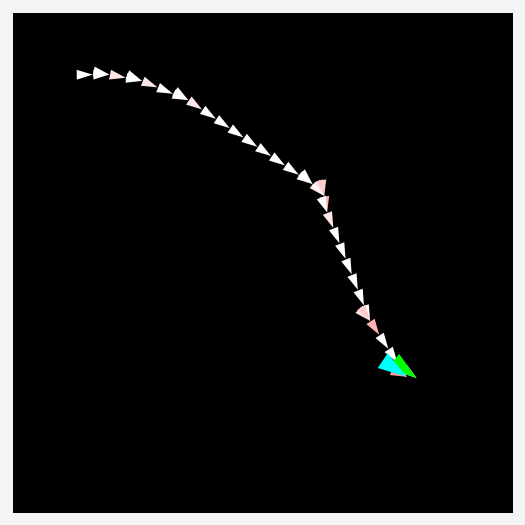

In [103]:

i += 1
draw_trajectory(ep_pos[i], ep_angle[i])

In [100]:
pos = np.vstack(res['data']['pos'])

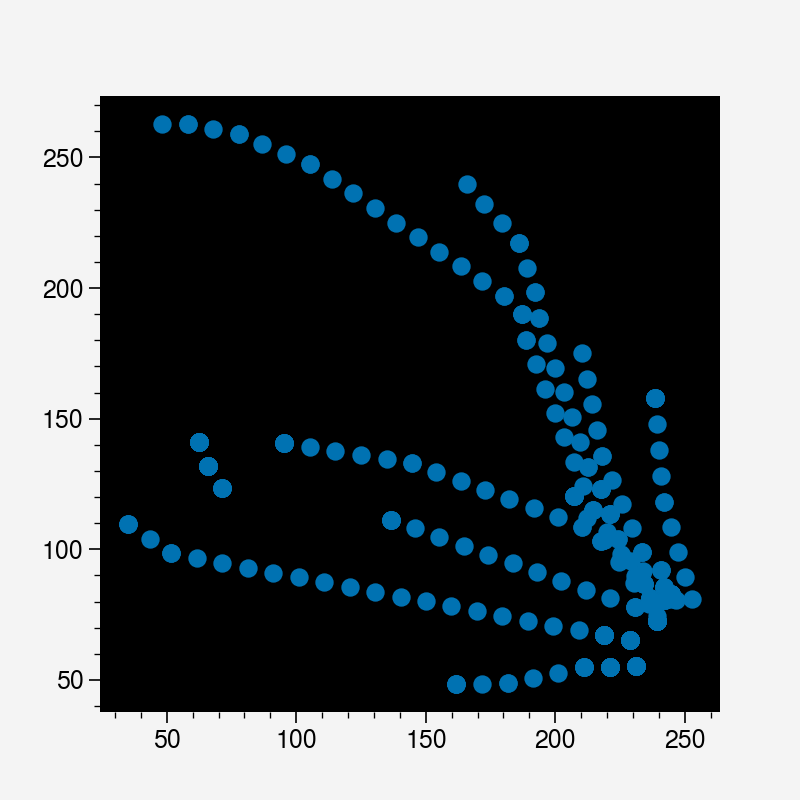

In [101]:
plt.scatter(pos.T[0], pos.T[1])

# Testing speed bottlenecks

Since we know that previous PPO could hit ~2000-3000SPS, but now we get closer to 300-600, let's double check to see where the implementation is bottlenecked

In [3]:
env_kwargs = {
        'num_objects': 0, 'rew_structure': 'goal',
        'task_structure': 2, 'wall_colors': 4,
        'num_rays': 12, 'fov': 1
}

agent = R2D2Agent(env_id='NavEnv-v0', env_kwargs=env_kwargs,
                 verbose=0, start_e=0, buffer_size=80000)

In [14]:
%%timeit


'''Collection: with epsilon=0, 500 steps of collection 
already takes about 500ms, taking about 50% of our SPS budget. 
Might need to be vectorizing/parallelizing'''

agent.collect(500)

459 ms ± 14.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [101]:
%%timeit

'''Simulation: takes about 20% of the acting time'''

env = agent.env

env.reset()
for i in range(640):
    obs, r, done, info = env.step(env.action_space.sample())
    if done:
        env.reset()

154 ms ± 14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [124]:
agent.collect(80000)

In [121]:
%%timeit
sample = agent.rb.sample(64//4)

582 µs ± 46.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [122]:
%%timeit
sample = agent.rb.sample(256//4)

620 µs ± 36.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [125]:
%%timeit
sample = agent.rb.sample(64//4)

2.32 ms ± 124 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [126]:
%%timeit
sample = agent.rb.sample(256//4)

2.32 ms ± 178 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Batched and vectorized envs

In [59]:
env_kwargs = {
        'num_objects': 0, 'rew_structure': 'goal',
        'task_structure': 2, 'wall_colors': 4,
        'num_rays': 12, 'fov': 1
}

agent = R2D2Agent(env_id='NavEnv-v0', env_kwargs=env_kwargs,
                 verbose=0, start_e=0.5, buffer_size=80000, n_envs=1)

In [67]:
rnn_hxs = agent.get_rnn_hxs()
obs = agent.env.reset()
obs = torch.tensor(obs).unsqueeze(1)

action, q, next_rnn_hxs = agent.act(obs, rnn_hxs)
next_obs, rew, done, info = agent.env.step(action)
masks = torch.FloatTensor(
    [[0.0] if done_ else [1.0] for done_ in done])


In [128]:
agent.collect(2000)

In [5]:
agent.update()

In [16]:
%%timeit
agent.update()

12.8 ms ± 218 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [122]:
env_kwargs = {
        'num_objects': 0, 'rew_structure': 'goal',
        'task_structure': 2, 'wall_colors': 4,
        'num_rays': 12, 'fov': 1
}

agent = R2D2Agent(env_id='NavEnv-v0', env_kwargs=env_kwargs,
                 verbose=0, start_e=0.5, buffer_size=80000, n_envs=1)

action, q, next_rnn_hxs = agent.act(agent.obs, agent.rnn_hxs, masks=agent.masks)
next_obs, rew, done, info = agent.env.step(action)
agent.masks = torch.FloatTensor(
    [[0.0] if done_ else [1.0] for done_ in done])

agent.obs = next_obs
agent.rnn_hxs = next_rnn_hxs


In [52]:
sample = agent.rb.sample(agent.batch_size//agent.sequence_length)
states = sample['observations']
next_states = sample['next_observations']
hidden_states = sample['hidden_states']
next_hidden_states = sample['next_hidden_states']
actions = sample['actions']
rewards = sample['rewards']
dones = sample['dones']
next_dones = sample['next_dones']

with torch.no_grad():
    target_q, _, _ = agent.target_network(next_states, next_hidden_states, next_dones)
    target_max, _ = target_q.max(dim=2)
    td_target = rewards + agent.gamma * target_max * (1 - dones)
old_q, _, _ = agent.q_network(states, hidden_states, dones)
old_val = old_q.gather(2, actions.long()).squeeze()

In [5]:
envs = make_vec_envs('NavEnv-v0',  2, env_kwargs=env_kwargs)
rb = SequenceReplayBuffer(10000, envs.observation_space, envs.action_space,
                     64, 4, 2, 2)
rnn_hxs2 = agent.q_network.get_rnn_hxs(2)

In [3]:
'''Run steps manually'''

obs = agent.env.reset()
rnn_hxs = agent.q_network.get_rnn_hxs()
for i in range(500):
    action, q_values, next_rnn_hxs = agent.act(obs, rnn_hxs)
    next_obs, reward, done, info = agent.env.step(action.item())
    
    if reward == 1:
        break
        
    if done:
        next_obs = agent.env.reset()
        next_rnn_hxs = agent.q_network.get_rnn_hxs()
    
    obs = next_obs
    rnn_hxs = next_rnn_hxs

R2D2Agent(
  (q_network): RNNQNetwork(
    (relu): ReLU()
    (gru): ResettingGRUBatched(
      (gru): GRU(24, 64, batch_first=True)
    )
    (fc0): Linear(in_features=64, out_features=64, bias=True)
    (fc1): Linear(in_features=64, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=4, bias=True)
  )
  (target_network): RNNQNetwork(
    (relu): ReLU()
    (gru): ResettingGRUBatched(
      (gru): GRU(24, 64, batch_first=True)
    )
    (fc0): Linear(in_features=64, out_features=64, bias=True)
    (fc1): Linear(in_features=64, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=4, bias=True)
  )
)

In [51]:
env_kwargs = {
        'num_objects': 0, 'rew_structure': 'goal',
        'task_structure': 2, 'wall_colors': 4,
        'num_rays': 12, 'fov': 1
}

agent = R2D2Agent(env_id='NavEnv-v0', env_kwargs=env_kwargs,
                 verbose=0, start_e=0.5, buffer_size=80000, n_envs=1)

agent.train(1)

# Testing ResettingGRUBatched

Manual lines for debugging the forward call

In [50]:
env_kwargs = {
        'num_objects': 0, 'rew_structure': 'goal',
        'task_structure': 2, 'wall_colors': 4,
        'num_rays': 12, 'fov': 1
}

agent = R2D2Agent(env_id='NavEnv-v0', env_kwargs=env_kwargs,
                 verbose=0, start_e=0.5, buffer_size=80000, n_envs=16)
agent.collect(500)
sample = agent.rb.sample(agent.batch_size//agent.sequence_length)
states = sample['observations']
next_states = sample['next_observations']
hidden_states = sample['hidden_states']

gru = agent.q_network.gru.gru


In [51]:
agent.hidden_size

64

In [57]:
x.shape
num_batches

1

In [58]:
'''
For batched forward pass
    x: (N, L, H_in)
    hidden_state: (1, L, hidden_size)
    dones: (N, L)

For unbatched
    x: (L, H_in)
    hidden_state: (L, hidden_size)
    dones: (L,)

Note that in unbatched, we will actually turn it into a batch
    hence we have a line of unsqueezes
hidden_state has first dimension of 1 indicating 1 layer and not bi-directional

Output: full_out (N, L, hidden_size), full_hx_out (1, N, hidden_size)
    Note that full_hx_out is NOT GENERALLY the same as the rnn_hidden_state
    you would expect from standard gru unit, since we sometimes pad the ending
    More correct to generally just take the last step of full_out
'''
x = next_states
hidden_state = next_hidden_states
dones = next_dones
masks = None


if hidden_state.dim() == 2:
    hidden_state = hidden_state.unsqueeze(0)
    x = x.unsqueeze(0)
    dones = dones.unsqueeze(0)

num_batches = x.shape[0]

extra_rows = int(dones.sum().item())

#Generate a new padded x and rnn_hxs vector to batch forward pass
padded_x = torch.zeros((num_batches + extra_rows, x.shape[1], x.shape[2]))
padded_rnn_hxs = torch.zeros((hidden_state.shape[0], num_batches + extra_rows, hidden_state.shape[2]))

batchable_rows = (dones == 0).all(dim=1)
num_batchable_rows = batchable_rows.sum().item()
individual_rows = (~batchable_rows).argwhere().reshape(-1)

#First N rows will be taken from rows with no dones
padded_x[:num_batchable_rows] = x[batchable_rows]
padded_rnn_hxs[:, :num_batchable_rows, :] = hidden_state[:, batchable_rows, :]
# padded_rnn_hxs[:num_batchable_rows] = hidden_state[batchable_rows]

#Remaining rows will be filled out in order of rows with dones
cur_row_idx = num_batchable_rows
for i in individual_rows:
    breakpoints = (dones[i] == 1).argwhere()
    cur_idx = 0
    rnn_hx = hidden_state[:, i, :]

    for breakpoint in breakpoints:
        if breakpoint == 0:
            rnn_hx = agent.get_rnn_hxs()
            continue
        padded_x[cur_row_idx, :breakpoint-cur_idx, :] = x[i, cur_idx:breakpoint, :]
        padded_rnn_hxs[:, cur_row_idx, :] = rnn_hx
        # padded_rnn_hxs[cur_row_idx] = rnn_hx

        rnn_hx = agent.get_rnn_hxs()
        cur_idx = breakpoint
        cur_row_idx += 1

    if cur_idx < len(dones[i]):
        padded_x[cur_row_idx, :len(dones[i])-cur_idx, :] = x[i, cur_idx:, :]
        padded_rnn_hxs[:, cur_row_idx, :] = rnn_hx
        # padded_rnn_hxs[cur_row_idx] = rnn_hx
        cur_row_idx += 1

#Perform forward pass on new batched
output, output_hx = gru(padded_x, padded_rnn_hxs)

#Fill out the expected output by reversing the whole process
full_out = torch.zeros((x.shape[0], x.shape[1], agent.hidden_size))
full_hx_out = torch.zeros((1, x.shape[0], agent.hidden_size))

full_out[batchable_rows] = output[:num_batchable_rows]
full_hx_out[:, batchable_rows, :] = output_hx[:, :num_batchable_rows, :]
# full_hx_out[batchable_rows] = output_hx[:num_batchable_rows]

cur_row_idx = num_batchable_rows
for i in individual_rows:
    breakpoints = (dones[i] == 1).argwhere()
    cur_idx = 0

    for breakpoint in breakpoints:
        if breakpoint == 0:
            continue
        full_out[i, cur_idx:breakpoint, :] = output[cur_row_idx, :breakpoint-cur_idx, :]

        cur_idx = breakpoint
        cur_row_idx += 1

    if cur_idx < len(dones[i]):
        full_out[i, cur_idx:, :] = output[cur_row_idx, :len(dones[i])-cur_idx, :]

        #Remember only the last rnn hidden state gets returned
        full_hx_out[:, i, :] = output_hx[:, cur_row_idx, :]
        # full_hx_out[i] = output_hx[cur_row_idx]
        cur_row_idx += 1
    else:
        #If we did not have remaining steps to fill, then we must have had a done
        # on the last step, so the final rnn_hx should be zeros to return
        full_hx_out[:, i, :] = agent.get_rnn_hxs()
        # full_hx_out[i] = self.get_rnn_hxs()



# Test loaded model

In [39]:
q_network = torch.load('../saved_models/mwm_batch1024_t0.pt')
agent = R2D2Agent(env_id='NavEnv-v0', env_kwargs=env_kwargs, q_network=q_network,
                 verbose=2, start_e=0.05, n_envs=4)


In [40]:
agent.collect(2000)

Episode R: 1.0, L: 23.0
Episode R: 1.0, L: 27.0
Episode R: 1.0, L: 23.0
Episode R: 1.0, L: 9.0
Episode R: 1.0, L: 84.0
Episode R: 1.0, L: 77.0
Episode R: 1.0, L: 11.0
Episode R: 1.0, L: 38.0
Episode R: 0.0, L: 202.0
Episode R: 1.0, L: 157.0
Episode R: 1.0, L: 70.0
Episode R: 0.0, L: 202.0
Episode R: 1.0, L: 18.0
Episode R: 1.0, L: 14.0
Episode R: 1.0, L: 49.0
Episode R: 0.0, L: 202.0
Episode R: 1.0, L: 35.0
Episode R: 0.0, L: 202.0
Episode R: 1.0, L: 24.0
Episode R: 1.0, L: 39.0
Episode R: 1.0, L: 9.0
Episode R: 0.0, L: 202.0
Episode R: 1.0, L: 41.0
Episode R: 1.0, L: 29.0
Episode R: 0.0, L: 202.0
Episode R: 0.0, L: 202.0
Episode R: 1.0, L: 41.0
Episode R: 1.0, L: 10.0
Episode R: 1.0, L: 36.0
Episode R: 1.0, L: 16.0
Episode R: 0.0, L: 202.0
Episode R: 0.0, L: 202.0
Episode R: 1.0, L: 28.0
Episode R: 0.0, L: 202.0
Episode R: 1.0, L: 63.0
Episode R: 0.0, L: 202.0
Episode R: 0.0, L: 202.0
Episode R: 1.0, L: 9.0
Episode R: 1.0, L: 15.0
Episode R: 0.0, L: 202.0
Episode R: 0.0, L: 202.0
Epis

# PER testing

In [3]:
import sys
sys.path.append('../r2d2_algo')
from segment_tree import MinSegmentTree, SumSegmentTree

In [4]:
import numpy as np
from gym import spaces
import torch

'''
Class definnitions for replay buffer used in off-policy training
'''

class SequenceReplayBuffer:
    def __init__(self, buffer_size, observation_space,
                 action_space, hidden_state_size, sequence_length=1,
                 burn_in_length=0, n_envs=1,
                 alpha=0.6, beta=0.4, 
                 beta_increment=0.0001, max_priority=1.0):
        '''
        A replay buffer for R2D2 algorithm that when sampled, produces sequences of time steps.
        Any index can be samples from, and burn_in_length steps before the index and sequence_length
          steps after the index will be passed together
        Note that there is one torch tensor per variable (observations, actions, rewards, dones, rnn_hxs)
          and it will continuously be overwritten. Each tensor has length burn_in_length+buffer_size+sequence_length.
          Think of it as having buffer_size, plus a chunk behind and ahead to handle burn in and sequence.
          
        self.pos keeps track of the next index to be written to. When it reaches the end (burn_in_length+buffer_size)
          it loops back to the start (burn_in_length).
          When it loops back, the burn_in_length chunk is copied from the end of the buffer.
          As it covers the the first sequence_length worth of steps in the buffer, these get copied to the end
            sequence_length chunk of the buffer
        
        buffer_size: number of steps to hold in buffer
        sequence_length: number of steps in sequence
        burn_in_length: number of steps before idx to be passed with sequence
        
        Priorities
        '''
        self.buffer_size = buffer_size
        total_buffer_size = buffer_size + sequence_length + burn_in_length
        self.n_envs = n_envs
        self.sequence_length = sequence_length
        self.burn_in_length = burn_in_length
        self.alpha = alpha
        self.beta = beta
        self.beta_increment = beta_increment
        self.max_priority = max_priority

        self.td_priorities = np.zeros(total_buffer_size*n_envs) #holds individual td errors for priority calculations
        # capacity must be positive and a power of 2.
        tree_capacity = 1
        while tree_capacity < total_buffer_size*n_envs:
            tree_capacity *= 2
        self.sum_tree = SumSegmentTree(tree_capacity) #trees hold actual priorities for faster updating and sampling
        self.min_tree = MinSegmentTree(tree_capacity)
        self.total_buffer_size = total_buffer_size
        
        action_shape = get_action_dim(action_space)
        self.observations = np.zeros((total_buffer_size, n_envs, *observation_space.shape), dtype=observation_space.dtype)
        self.actions = np.zeros((total_buffer_size, n_envs, action_shape), dtype=action_space.dtype)
        self.rewards = np.zeros((total_buffer_size, n_envs), dtype=np.float32)
        self.dones = np.zeros((total_buffer_size, n_envs), dtype=np.float32)
        self.hidden_states = np.zeros((total_buffer_size, n_envs, hidden_state_size), dtype=np.float32)

        
        self.pos = burn_in_length
        self.full = False
        
    def add(self, obs, next_obs, action, reward, done, hidden_state):
        '''
        Add to the buffer
        '''
        bil = self.burn_in_length
        bs = self.buffer_size
        sl = self.sequence_length

        
        self.observations[self.pos] = np.array(obs).copy()
        self.observations[(self.pos + 1) % self.buffer_size] = np.array(next_obs).copy()
        self.actions[self.pos] = np.array(action).copy()
        self.rewards[self.pos] = np.array(reward).copy()
        self.dones[self.pos] = np.array(done).copy()
        self.hidden_states[self.pos] = np.array(hidden_state).copy()
        
        for i in range(self.n_envs):
            self.td_priorities[self.pos + i*self.total_buffer_size] = self.max_priority
            # 0 out probabilities for indexes that become invalid
            self.sum_tree[self.pos + i*self.total_buffer_size] = 0.
            self.sum_tree[self.pos + i*self.total_buffer_size + bil] = 0.
        if (self.full and self.pos >= bil + sl) or (self.pos >= 2*bil + sl):
            # only update steps in the past 
            #  there is a very slight chance this overwrites some priority that was set in 
            #  an update step but shouldn't make a huge difference
            for i in range(self.n_envs):
                self.sum_tree[self.pos + i*self.total_buffer_size - sl] = self.max_priority ** self.alpha
                self.min_tree[self.pos + i*self.total_buffer_size - sl] = self.max_priority ** self.alpha
        
        
        #Make copies to extra end portion
        #Note that this makes it so that for a sequence_length period of time
        #while we are filling up the end of the buffer, end steps cannot be used
        if self.pos < bil + sl:
            self.observations[self.pos+bs] = self.observations[self.pos].copy()
            self.actions[self.pos+bs] = self.actions[self.pos].copy()
            self.rewards[self.pos+bs] = self.rewards[self.pos].copy()
            self.dones[self.pos+bs] = self.dones[self.pos].copy()
            self.hidden_states[self.pos+bs] = self.hidden_states[self.pos].copy()
            
            # Copies of the end need to be made for td_priorities, but burn-in does not need
            #  These priorities are not true priorities, just used to later calculate total td
            #  for sequences. Hence they do not get copied to the sum_tree or min_tree
            for i in range(self.n_envs):
                self.td_priorities[self.pos+bs + i*self.total_buffer_size] = self.max_priority
                # self.sum_tree[self.pos+bs + i*self.total_buffer_size] = self.max_priority ** self.alpha
                # self.min_tree[self.pos+bs + i*self.total_buffer_size] = self.max_priority ** self.alpha

            
        self.pos += 1
        if self.pos == self.buffer_size + self.burn_in_length:
            self.pos = self.burn_in_length
            self.full = True
            
            #Make copies to the burn_in portion
            self.observations[:bil] = self.observations[bs:bs+bil].copy()
            self.actions[:bil] = self.actions[bs:bs+bil].copy()
            self.rewards[:bil] = self.rewards[bs:bs+bil].copy()
            self.dones[:bil] = self.dones[bs:bs+bil].copy()
            self.hidden_states[:bil] = self.hidden_states[bs:bs+bil].copy()

            
    def _sample_indices(self, num_sequences):
        '''
        Use sum tree to sample indices from priorities in segments
        '''
        t_indices = []
        env_indices = []
        p_total = self.sum_tree.sum()
        segment = p_total / num_sequences
        
        # Check if stratified sampling will be valid based on number
        #  of sequences asked for and fullness of storage        
        for i in range(num_sequences):
            found = False
            sample_attempt_count = 0
            valid_idxs = self.get_valid_idxs()
            
            a = segment * i
            b = segment * (i + 1)
            
            while not found and sample_attempt_count < 50:
                upperbound = random.uniform(a, b)
                idx = self.sum_tree.retrieve(upperbound)
                # print(idx)
                t_index = idx % self.total_buffer_size
                if valid_idxs[t_index]:
                    found = True
                sample_attempt_count += 1
            
            if sample_attempt_count >= 50:
                # If this happens, either buffer is not being filled enough before
                #  samples are being called for, or there is a bug
                print('Warning: sample index failed to find valid index 50 times')
                
            t_indices.append(idx % self.total_buffer_size)
            env_indices.append(idx // self.total_buffer_size)
            
        
        return np.array(t_indices), np.array(env_indices)
        
        
    def _calculate_weight(self, t_idx, env_idx):
        '''Calculate the weight of the experience at idx.'''
        # print(t_idx, env_idx)
        
        size = self.buffer_size if self.full else self.pos
        size = size * self.n_envs
        idx = t_idx + env_idx*self.total_buffer_size
        
        # get max weight
        p_min = self.min_tree.min() / self.sum_tree.sum()
        max_weight = (p_min * size) ** (-self.beta)
        
        # calculate weights
        p_sample = self.sum_tree[idx] / self.sum_tree.sum()
        weight = (p_sample * size) ** (-self.beta)
        weight = weight / max_weight
        
        return weight
        
    def sample(self, num_sequences):
        '''
        Generate a sample of data to be trained with from the buffer
        Note that we will actually generate a total training batch size of
            num_sequences*self.sequence_length
        and a total number of steps returned of
            num_sequences*(self.sequence_length+self.burn_in_length).
        It is up to the one calling sample to take into account how many
        sequence samples it wants
        '''
        t_idxs, env_idxs = self._sample_indices(num_sequences)
        start_idxs = t_idxs - self.burn_in_length
        
        window_idxs = np.arange(-self.burn_in_length, self.sequence_length)
        window_length = len(window_idxs)
        seq_idxs = t_idxs[:, np.newaxis] + window_idxs
        seq_env_idxs = np.full((num_sequences, window_length), env_idxs[:, np.newaxis])
        
        # weights are [N, 1] tensor to be multiplied to each sequence batch generaated
        weights = torch.Tensor([self._calculate_weight(t_idxs[i], env_idxs[i]) \
                                for i in range(num_sequences)]).reshape(-1, 1)

        self.beta = min(1.0, self.beta + self.beta_increment)
                
        obs = torch.Tensor(self.observations[seq_idxs, seq_env_idxs])
        next_obs = torch.Tensor(self.observations[seq_idxs+1, seq_env_idxs])
        actions = torch.Tensor(self.actions[seq_idxs, seq_env_idxs])
        rewards = torch.Tensor(self.rewards[seq_idxs, seq_env_idxs])
        dones = torch.Tensor(self.dones[seq_idxs, seq_env_idxs])
        next_dones = torch.Tensor(self.dones[seq_idxs+1, seq_env_idxs])
        
        hidden_states = torch.Tensor(self.hidden_states[start_idxs, env_idxs]).unsqueeze(0)
        next_hidden_states = torch.Tensor(self.hidden_states[start_idxs+1, env_idxs]).unsqueeze(0)
        
        sample = {
            'observations': obs,
            'next_observations': next_obs,
            'actions': actions,
            'rewards': rewards,
            'dones': dones,
            'next_dones': next_dones,
            'hidden_states': hidden_states,
            'next_hidden_states': next_hidden_states,
            'weights': weights,
            't_idxs': t_idxs,
            'seq_idxs': seq_idxs,
            'env_idxs': env_idxs,
        }
        
        return sample
    
    
    def get_valid_idxs(self):
        '''
        Get array of valid indexes that can be sampled. Valid indexes are those with enough time steps
        of data earlier to match burn_in_lenth and with enough time steps of data later to match
        sequence_length.
        
        return a self.total_buffer_size (bil+buffer_size+seq_len) boolean array
            that can be checked for truth by indexing directly
        
        Note: there is a slight bug here to be fixed in the future - there is a period where self.pos
          loops back that the sequence_length post buffer is stale until overwritten fully 
        '''        
        start = self.burn_in_length
        end = self.burn_in_length + self.buffer_size
        valid_idxs = np.full(self.total_buffer_size, False)
        if self.full:
            #Have enough terms ahead to be usable
            valid_idxs[start:self.pos - self.sequence_length] = True
            #Have enough terms behind to be usable
            valid_idxs[self.pos + self.burn_in_length-1:end] = True
        else:
            #First burn_in_length steps are not valid because they haven't been copied
            valid_idxs[start + self.burn_in_length:self.pos - self.sequence_length] = True
        
        return valid_idxs

    def update_priorities(self, seq_idxs, env_idxs, priorities):
        '''
        seq_idxs: shape [N, seq_len]
        env_idxs: shape [N,] for N batches
        priorities: shape [N, seq_len]
        '''
        
        valid_idxs = self.get_valid_idxs()
        
        n_batches = len(env_idxs)
        for i in range(n_batches):
            update_priority_idxs = seq_idxs[i] + env_idxs[i] * self.total_buffer_size
            self.td_priorities[update_priority_idxs] = priorities[i]

            for j in range(len(update_priority_idxs)):
                start = seq_idxs[i, j] + env_idxs[i]*self.total_buffer_size

                # check if the updated priority needs to be copied to buffer end segment
                if seq_idxs[i, j] < self.burn_in_length + self.sequence_length:
                    copy_idx = start + self.buffer_size
                    self.td_priorities[copy_idx] = priorities[i, j]

                if valid_idxs[seq_idxs[i, j]]:
                    # next update priority based on future td_steps
                    avg_td_priority = self.td_priorities[start:start+self.sequence_length].sum() / self.sequence_length
                    self.sum_tree[start] = avg_td_priority ** self.alpha
                    self.min_tree[start] = avg_td_priority ** self.alpha

    def __len__(self):
        return len(self.buffer)
    
    
    
    
def get_action_dim(action_space):
    """
    Get the dimension of the action space.
    """
    if isinstance(action_space, spaces.Box):
        return int(np.prod(action_space.shape))
    elif isinstance(action_space, spaces.Discrete):
        # Action is an int
        return 1
    elif isinstance(action_space, spaces.MultiDiscrete):
        # Number of discrete actions
        return int(len(action_space.nvec))
    elif isinstance(action_space, spaces.MultiBinary):
        # Number of binary actions
        assert isinstance(
            action_space.n, int
        ), "Multi-dimensional MultiBinary action space is not supported. You can flatten it instead."
        return int(action_space.n)
    else:
        raise NotImplementedError(f"{action_space} action space is not supported")

In [5]:
class R2D2Agent(nn.Module):
    def __init__(self, batch_size=128, burn_in_length=4, sequence_length=8,
                 gamma=0.99, tau=1., learning_rate=2.5e-4, hidden_size=64, adam_epsilon=1e-8,
                 device=torch.device('cpu'), buffer_size=10_000, 
                 learning_starts=10_000, train_frequency=10, target_network_frequency=500,
                 total_timesteps=30_000, start_e=1., end_e=0.05, exploration_fraction=0.5, 
                 alpha=0.6, beta=0.4,
                 seed=None, n_envs=1, dummy_env=True,
                 env_id='CartPole-v1', env_kwargs={},
                 verbose=0, q_network=None,  deterministic=False, env=None,
                 writer=None, handle_target_network=True, use_per=True):
        """
        R2D2 setup following same parameters as args.py has
        verbose: Level of verbosity of print statements
            1: print episode lengths and returns means every 2000 steps
            2: print every episode length and return
        q_network: Mostly for use of evaluation with a saved q_network
          optionally pass in a q_network to use manually
        deterministic: If True, manually set epsilon to 0 for every act() call
        env: Also option to manually pass in an environment
        n_envs: option to make multiple envs and have q_network generate multiple
        dummy_env: whether to use DummyVecEnv as opposed to SubprocVecEnv for testing
        writer: option to pass a tensorboard SummaryWriter object
        handle_target_network: whether this class is in charge of updating the target network
            params
        """
        
        super().__init__()
        
        self.learning_rate = learning_rate
        self.buffer_size = buffer_size
        self.total_timesteps = total_timesteps
        self.learning_starts = learning_starts
        self.train_frequency = train_frequency
        self.gamma = gamma
        self.tau = tau
        self.use_per = use_per
        self.adam_epsilon = adam_epsilon
        self.target_network_frequency = target_network_frequency
        self.handle_target_network = handle_target_network
        self.device = device

        self.start_e = start_e
        self.end_e = end_e
        self.exploration_fraction = exploration_fraction

        self.burn_in_length = burn_in_length
        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.n_envs = n_envs
        self.hidden_size = hidden_size

        self.seed = seed
        self.deterministic = deterministic
        if env == None:
            # self.env = gym.make(env_id, **env_kwargs)
            self.env = make_vec_envs(env_id, n_envs, env_kwargs=env_kwargs,
                                     dummy=dummy_env)
        else:
            self.env = env
        
        
        if q_network == None:
            self.q_network = RNNQNetwork(self.env, hidden_size).to(device)
        else:
            self.q_network = q_network
        self.target_network = RNNQNetwork(self.env, hidden_size).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate, eps=adam_epsilon)
        
        self.rb = SequenceReplayBuffer(buffer_size, self.env.observation_space, self.env.action_space,
                                hidden_size, sequence_length=sequence_length, 
                                burn_in_length=burn_in_length, n_envs=n_envs,
                                alpha=alpha, beta=beta)

        
        self.global_step = 0
        self.global_update_step = 0
        self.rnn_hxs = self.q_network.get_rnn_hxs(self.n_envs)
        self.obs = self.env.reset()
        self.masks = torch.zeros((self.n_envs, 1), dtype=torch.float32)
        
        self.cur_episode_t = np.zeros(self.n_envs)
        self.cur_episode_r = np.zeros(self.n_envs)
        
        self.verbose = verbose
        self.writer = writer
        self.start_time = time.time()
        self.lengths = []
        self.returns = []
        
    
    def act(self, obs, rnn_hxs, use_epsilon=True, masks=None):
        """Compute q values and sample policy. If epsilon is True,
        perform randomo action with probability based on current global timestep
        
        masks: tensor of shape (N, 1) which has entries 0.0 when done
            and 1.0 when not done, indicating when rnn_hxs should be reset
            Used for vectorized environments
        """            
        epsilon = self.get_epsilon(use_epsilon)
        
        obs_tensor = torch.Tensor(obs).to(self.device)
        if obs_tensor.dim() < rnn_hxs.dim():
            # We have an observation from the environment but need to unsqueeze
            #  to tell the GRU that this is an observation of time length 1
            # If it is batched (dim == 2), then we add an axis in the middle
            #  otherwise add it to the start
            if obs_tensor.dim() == 1:
                obs_tensor = obs_tensor.unsqueeze(0)
                action_dim = 1
            elif obs_tensor.dim() == 2:
                obs_tensor = obs_tensor.unsqueeze(1)
                action_dim = 2
        
        else:
            if obs_tensor.dim() == 2:
                action_dim = 1
            elif obs_tensor.dim() == 3:
                action_dim = 2  
            
        q_values, gru_out, next_rnn_hxs = self.q_network(obs_tensor, rnn_hxs, masks=masks)
                
        
        # action = np.array([[q_values.argmax()]])
        action = q_values.argmax(dim=action_dim).numpy()
        if use_epsilon:
            if len(action.shape) == 1:
                for i in range(action.shape[0]):
                    if random.random() < epsilon:
                        action[i] = self.env.action_space.sample()
            elif len(action.shape) == 2:
                for i in range(action.shape[0]):
                    for j in range(action.shape[1]):
                        if random.random() < epsilon:
                            action[i, j] = self.env.action_space.sample()
            
        if len(action.shape) == 1:
            action = action[np.newaxis, :]

        return action, q_values, next_rnn_hxs
                
        
    def collect(self, num_steps):
        """Perform policy for n steps and add to memory buffer
        
        Note that we will add a total of num_steps * self.n_envs to the buffer"""
        env = self.env
        
        for t in range(num_steps):
            action, q_values, next_rnn_hxs = self.act(self.obs, self.rnn_hxs, masks=self.masks)
            next_obs, reward, done, info = env.step(action)
            
            self.cur_episode_r += reward
            self.cur_episode_t += 1
            
            # if done:
            #     next_obs = env.reset()
            #     next_rnn_hxs = self.q_network.get_rnn_hxs()
                
            #     if self.verbose >= 1:
            #         print(f'Episode R: {self.cur_episode_r}, L: {self.cur_episode_t}')
                
            #     self.cur_episode_t = 0
            #     self.cur_episode_r = 0

            # Masks are used to reset hidden state when vectorized environmnts give dones
            self.masks = torch.FloatTensor(
                [[0.0] if done_ else [1.0] for done_ in done])

            for i, done_ in enumerate(done):
                if done_:
                    if self.verbose == 2:
                        print(f'Episode R: {self.cur_episode_r[i]}, L: {self.cur_episode_t[i]}')
                        
                    if self.writer is not None:
                        self.writer.add_scalar('charts/episodic_return', self.cur_episode_r[i], self.global_step)
                        self.writer.add_scalar('charts/episodic_length', self.cur_episode_t[i], self.global_step)
                        self.writer.add_scalar('charts/epsilon', self.get_epsilon(), self.global_step)

                    self.lengths.append(self.cur_episode_t[i])
                    self.returns.append(self.cur_episode_r[i])
                    
                    self.cur_episode_r[i] = 0
                    self.cur_episode_t[i] = 0
                    

            self.rb.add(self.obs, next_obs, action, reward, done, self.rnn_hxs.detach())
            
            self.obs = next_obs
            self.rnn_hxs = next_rnn_hxs
            
            self.global_step += self.n_envs
            
            if self.handle_target_network and self.global_step > self.learning_starts and \
                self.global_step % self.target_network_frequency < self.n_envs:
                for target_network_param, q_network_param in zip(self.target_network.parameters(), self.q_network.parameters()):
                    target_network_param.data.copy_(
                        self.tau * q_network_param.data + (1 - self.tau) * target_network_param.data
                    )
            
            if self.global_step % 2000 < self.n_envs:
                if self.verbose == 1:
                    print(f'Mean episode length {np.mean(self.lengths)}, mean return {np.mean(self.returns)}')
                self.lengths = []
                self.returns = []

                
            
    
    def update(self):
        """Sample from buffer and perform Q-learning"""
        
        sample = self.rb.sample(self.batch_size//self.sequence_length)
        states = sample['observations']
        next_states = sample['next_observations']
        hidden_states = sample['hidden_states']
        next_hidden_states = sample['next_hidden_states']
        actions = sample['actions']
        rewards = sample['rewards']
        dones = sample['dones']
        next_dones = sample['next_dones']
        
        with torch.no_grad():
            target_q, _, _ = self.target_network(next_states, next_hidden_states, next_dones)
            target_max, _ = target_q.max(dim=2)
            td_target = rewards + self.gamma * target_max * (1 - dones)
        old_q, _, _ = self.q_network(states, hidden_states, dones)
        old_val = old_q.gather(2, actions.long()).squeeze()

        # loss = F.mse_loss(td_target[:, self.burn_in_length:], old_val[:, self.burn_in_length:])
        weights = sample['weights']
        elementwise_loss = F.smooth_l1_loss(td_target[:, self.burn_in_length:],
                                            old_val[:, self.burn_in_length:], reduction='none')
        loss = torch.mean(elementwise_loss * weights)
                
        if self.writer is not None and self.global_update_step % 10 == 0:
            self.writer.add_scalar('losses/td_loss', loss, self.global_step)
            self.writer.add_scalar('losses/q_values', old_val.mean().item(), self.global_step)
            sps = int(self.global_step / (time.time() - self.start_time))
            # print('SPS:', int(sps))
            self.writer.add_scalar('charts/SPS', sps, self.global_step)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # PER: update priorities
        td_priorities = elementwise_loss.detach().cpu().numpy() + 1e-6
        self.rb.update_priorities(sample['seq_idxs'][:, self.burn_in_length:],
                                  sample['env_idxs'], td_priorities)
        
        self.global_update_step += 1
    

    def train(self, n_updates):
        if self.global_step < self.learning_starts:
            self.collect((self.learning_starts - self.global_step) // self.n_envs + 1)
        
        for i in range(n_updates):
            self.collect(self.train_frequency)
            self.update()


    def get_rnn_hxs(self):
        return self.q_network.get_rnn_hxs(self.n_envs)
    
    def get_epsilon(self, use_epsilon=True):
        if use_epsilon:
            epsilon = linear_schedule(self.start_e, self.end_e, 
                        self.exploration_fraction*self.total_timesteps,
                        self.global_step)
        else:
            epsilon = 0
            
        return epsilon

In [2]:
env_kwargs = {
        'num_objects': 0, 'rew_structure': 'goal',
        'task_structure': 2, 'wall_colors': 4,
        'num_rays': 12, 'fov': 1
}

agent = R2D2Agent(env_id='NavEnv-v0', env_kwargs=env_kwargs,
                 verbose=1, buffer_size=5000, alpha=0.6, batch_size=256,
                 burn_in_length=8, n_envs=4, dummy_env=True)

In [3]:
agent.collect(3000)

Mean episode length 202.0, mean return 0.0
Mean episode length 202.0, mean return 0.0
Mean episode length 202.0, mean return 0.0
Mean episode length 202.0, mean return 0.0
Mean episode length 177.85714285714286, mean return 0.14285714285714285
Mean episode length 202.0, mean return 0.0


In [417]:
%%timeit
agent.collect(1000)

Mean episode length 202.0, mean return 0.0
Mean episode length 202.0, mean return 0.0
Mean episode length 202.0, mean return 0.0
Mean episode length 202.0, mean return 0.0
820 ms ± 28 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
%%timeit
agent.collect(2)

Mean episode length 187.15384615384616, mean return 0.07692307692307693
Mean episode length 202.0, mean return 0.0
Mean episode length 187.23076923076923, mean return 0.07692307692307693
4.53 ms ± 176 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
%%timeit
agent.collect(2)

Mean episode length 202.0, mean return 0.0
Mean episode length 202.0, mean return 0.0
Mean episode length 202.0, mean return 0.0
3.7 ms ± 53.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [431]:
%%timeit
agent.collect(2)

Mean episode length 202.0, mean return 0.0
Mean episode length 202.0, mean return 0.0
Mean episode length 202.0, mean return 0.0
2.02 ms ± 82 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
%%timeit
agent.update()

35.9 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [433]:
%%timeit
agent.update()

34.1 ms ± 2.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
%%timeit
agent.update()

21.1 ms ± 918 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
%%timeit
sample = agent.rb.sample(32)

826 µs ± 12.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [7]:
sample = agent.rb.sample(256//8)
states = sample['observations']
next_states = sample['next_observations']
hidden_states = sample['hidden_states']
next_hidden_states = sample['next_hidden_states']
actions = sample['actions']
rewards = sample['rewards']
dones = sample['dones']
next_dones = sample['next_dones']

with torch.no_grad():
    target_q, _, _ = agent.target_network(next_states, next_hidden_states, next_dones)
    target_max, _ = target_q.max(dim=2)
    td_target = rewards + agent.gamma * target_max * (1 - dones)
old_q, _, _ = agent.q_network(states, hidden_states, dones)
old_val = old_q.gather(2, actions.long()).squeeze()

old_loss = F.mse_loss(td_target[:, agent.burn_in_length:], old_val[:, agent.burn_in_length:])
weights = sample['weights']
elementwise_loss = F.smooth_l1_loss(td_target[:, agent.burn_in_length:],
                                    old_val[:, agent.burn_in_length:], reduction='none')
loss = torch.mean(elementwise_loss * weights)


In [8]:
weights

tensor([[0.0204],
        [0.0204],
        [0.0204],
        [0.0204],
        [0.0204],
        [0.0204],
        [0.1248],
        [0.0204],
        [0.0204],
        [0.0204],
        [0.0204],
        [0.0204],
        [0.0204],
        [0.0204],
        [0.0204],
        [0.0204],
        [0.0204],
        [0.0204],
        [0.0204],
        [0.0204],
        [0.0204],
        [0.0204],
        [0.0204],
        [0.0204],
        [0.0204],
        [0.0204],
        [0.0204],
        [0.0204],
        [0.0204],
        [0.0204],
        [0.0204],
        [0.0204]])

In [15]:
%%timeit
with torch.no_grad():
    target_q, _, _ = agent.target_network(next_states, next_hidden_states, next_dones)
    target_max, _ = target_q.max(dim=2)
    td_target = rewards + agent.gamma * target_max * (1 - dones)
old_q, _, _ = agent.q_network(states, hidden_states, dones)
old_val = old_q.gather(2, actions.long()).squeeze()

old_loss = F.mse_loss(td_target[:, agent.burn_in_length:], old_val[:, agent.burn_in_length:])
weights = sample['weights']
elementwise_loss = F.smooth_l1_loss(td_target[:, agent.burn_in_length:],
                                    old_val[:, agent.burn_in_length:], reduction='none')
loss = torch.mean(elementwise_loss * weights)


9.42 ms ± 254 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
%%timeit
with torch.no_grad():
    target_q, _, _ = agent.target_network(next_states, next_hidden_states, next_dones)
    target_max, _ = target_q.max(dim=2)
    td_target = rewards + agent.gamma * target_max * (1 - dones)
old_q, _, _ = agent.q_network(states, hidden_states, dones)
old_val = old_q.gather(2, actions.long()).squeeze()

old_loss = F.mse_loss(td_target[:, agent.burn_in_length:], old_val[:, agent.burn_in_length:])
weights = sample['weights']
elementwise_loss = F.smooth_l1_loss(td_target[:, agent.burn_in_length:],
                                    old_val[:, agent.burn_in_length:], reduction='none')
loss = torch.mean(elementwise_loss * weights)

agent.optimizer.zero_grad()
loss.backward()
agent.optimizer.step()

15.6 ms ± 401 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [32]:
%%timeit
td_priorities = elementwise_loss.detach().cpu().numpy() + 1e-6
agent.rb.update_priorities(sample['seq_idxs'][:, agent.burn_in_length:],
                          sample['env_idxs'], td_priorities)


12 ms ± 258 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [34]:
seq_idxs = sample['seq_idxs'][:, agent.burn_in_length:]
env_idxs = sample['env_idxs']
priorities = td_priorities
rb = agent.rb

In [41]:
%%timeit
n_batches = len(env_idxs)
for i in range(n_batches):
    update_priority_idxs = seq_idxs[i] + env_idxs[i] * rb.total_buffer_size
    rb.td_priorities[update_priority_idxs] = priorities[i]


144 µs ± 1.63 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [40]:
%%timeit
n_batches = len(env_idxs)
for i in range(n_batches):
    update_priority_idxs = seq_idxs[i] + env_idxs[i] * rb.total_buffer_size
    rb.td_priorities[update_priority_idxs] = priorities[i]

    for j in range(len(update_priority_idxs)):
        start = seq_idxs[i, j] + env_idxs[i]*rb.total_buffer_size


318 µs ± 28.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [122]:
%%timeit
valid_idxs = rb.get_valid_idxs()

n_batches = len(env_idxs)
for i in range(n_batches):
    update_priority_idxs = seq_idxs[i] + env_idxs[i] * rb.total_buffer_size
    rb.td_priorities[update_priority_idxs] = priorities[i]

    for j in range(len(update_priority_idxs)):
        start = seq_idxs[i, j] + env_idxs[i]*rb.total_buffer_size
        
        # check if the updated priority needs to be copied to buffer end segment
        if seq_idxs[i, j] < rb.burn_in_length + rb.sequence_length:
            copy_idx = start + rb.buffer_size
            rb.td_priorities[copy_idx] = priorities[i, j]

        if valid_idxs[seq_idxs[i, j]]:
            # next update priority based on future td_steps
            avg_td_priority = rb.td_priorities[start:start+rb.sequence_length].sum() / rb.sequence_length
            rb.sum_tree[start] = avg_td_priority ** rb.alpha
            rb.min_tree[start] = avg_td_priority ** rb.alpha


11.1 ms ± 186 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [63]:
%%timeit
valid_idxs = rb.get_valid_idxs()

n_batches = len(env_idxs)
for i in range(n_batches):
    update_priority_idxs = seq_idxs[i] + env_idxs[i] * rb.total_buffer_size
    rb.td_priorities[update_priority_idxs] = priorities[i]


for i, j in zip(seq_idxs):
    start = seq_idxs[i, j] + env_idxs[i]*rb.total_buffer_size

    avg_td_priority = rb.td_priorities[start:start+rb.sequence_length].sum() / rb.sequence_length
    rb.sum_tree[start] = avg_td_priority ** rb.alpha
    rb.min_tree[start] = avg_td_priority ** rb.alpha


10.9 ms ± 219 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [80]:
starts = seq_idxs + env_idxs.reshape(-1, 1) * rb.total_buffer_size



In [101]:
%%timeit

mesh = np.meshgrid(range(starts.shape[0]), range(starts.shape[1]))
for i, j in zip(mesh[0].reshape(-1), mesh[1].reshape(-1)):
    rb.sum_tree[starts[i, j]] = avg_td_priority ** rb.alpha

4.82 ms ± 45.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [102]:
%%timeit
rb.sum_tree[starts[i, j]] = avg_td_priority ** rb.alpha

17.6 µs ± 160 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [105]:
p = rb.sum_tree.tree[cap:]

In [108]:
%%timeit
np.sum(p)

2.03 ms ± 94 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [113]:
%%timeit
p_cumsum = np.cumsum(p)

2.77 ms ± 527 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [126]:
%%timeit
p_cum = np.cumsum(p)
p_total = p_cum[-1]
rands = np.random.random(5) * p_total
idxs = (p_cum.reshape(-1, 1) > rands).argmax(axis=0)

2.99 ms ± 55.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [127]:
p_cum = np.cumsum(p)
p_total = p_cum[-1]
rands = np.random.random(5) * p_total
idxs = (p_cum.reshape(-1, 1) > rands).argmax(axis=0)

In [129]:
idxs % rb.total_buffer_size

array([2687, 2091, 1022, 3680, 3614], dtype=int64)

In [130]:
idxs // rb.total_buffer_size

array([0, 0, 3, 3, 3], dtype=int64)

In [131]:
rb.__len__()

AttributeError: 'SequenceReplayBuffer' object has no attribute 'buffer'

In [125]:
%%timeit
min(5, 10)

142 ns ± 2.51 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [85]:
for i, j in zip(range(starts.shape[0]), range(starts.shape[1])):
    print(i, j)

0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7


In [60]:

count = 0
valid_idxs = rb.get_valid_idxs()
n_batches = len(env_idxs)
for i in range(n_batches):
    update_priority_idxs = seq_idxs[i] + env_idxs[i] * rb.total_buffer_size
    rb.td_priorities[update_priority_idxs] = priorities[i]

    for j in range(len(update_priority_idxs)):
        start = seq_idxs[i, j] + env_idxs[i]*rb.total_buffer_size
        
        # check if the updated priority needs to be copied to buffer end segment
        if seq_idxs[i, j] < rb.burn_in_length + rb.sequence_length:
            copy_idx = start + rb.buffer_size
            rb.td_priorities[copy_idx] = priorities[i, j]

        if valid_idxs[seq_idxs[i, j]]:
            count += 1
            # next update priority based on future td_steps
            avg_td_priority = rb.td_priorities[start:start+rb.sequence_length].sum() / rb.sequence_length
            rb.sum_tree[start] = avg_td_priority ** rb.alpha
            rb.min_tree[start] = avg_td_priority ** rb.alpha

In [61]:
count

256

In [ ]:
cap = rb.sum_tree.capacity

In [67]:
%%timeit
random.random()

74.6 ns ± 0.826 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [70]:
%%timeit
avg_td_priority ** rb.alpha

228 ns ± 6.35 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [71]:
%%timeit
rb.sum_tree[5] = avg_td_priority ** rb.alpha

6.71 µs ± 198 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [52]:
%%timeit
rb.sum_tree.tree[cap+5] = 1

125 ns ± 1.47 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [42]:
%%timeit
n_batches = len(env_idxs)
for i in range(n_batches):
    update_priority_idxs = seq_idxs[i] + env_idxs[i] * rb.total_buffer_size
    rb.td_priorities[update_priority_idxs] = priorities[i]

    for j in range(len(update_priority_idxs)):
        start = seq_idxs[i, j] + env_idxs[i]*rb.total_buffer_size
        
        # check if the updated priority needs to be copied to buffer end segment
        if seq_idxs[i, j] < rb.burn_in_length + rb.sequence_length:
            copy_idx = start + rb.buffer_size
            rb.td_priorities[copy_idx] = priorities[i, j]



408 µs ± 20.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [37]:
update_priority_idxs

array([19155, 19156, 19157, 19158, 19159, 19160, 19161, 19162])

In [22]:
%%timeit
agent.rb.sum_tree[5] = 1

6.22 µs ± 137 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [13]:
states.shape

torch.Size([32, 16, 24])

In [446]:
nd = dones[-1, :-1]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

In [281]:
update_seq_idxs = sample['seq_idxs'][:, agent.burn_in_length:]
seq_idxs = update_seq_idxs

priorities = elementwise_loss.detach().numpy()
env_idxs = sample['env_idxs']


n_batches = len(env_idxs)
for i in range(n_batches):
    update_priority_idxs = seq_idxs[i] + env_idxs[i] * agent.rb.total_buffer_size
    agent.rb.td_priorities[update_priority_idxs] = priorities[i]
    
    for j in range(len(update_priority_idxs)):
        start = seq_idxs[i, j] + env_idxs[i]*agent.rb.total_buffer_size
        
        # check if the updated priority needs to be copied to buffer end segment
        if seq_idxs[i, j] < agent.rb.burn_in_length + agent.rb.sequence_length:
            copy_idx = start + agent.rb.buffer_size
            agent.rb.td_priorities[copy_idx] = priorities[i, j]
        # next update priority based on future td_steps
        avg_td_priority = agent.rb.td_priorities[start:start+agent.rb.sequence_length].sum() / agent.rb.sequence_length
        agent.rb.sum_tree[start] = avg_td_priority ** agent.rb.alpha
        agent.rb.min_tree[start] = avg_td_priority ** agent.rb.alpha
    